In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import glob
import yaml
import torchvision

In [6]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # for cuda
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
set_seed(0)

In [2]:
def extract_files():
    import google.colab
    import zipfile

    google.colab.drive.mount('/content/drive')
    PROJECT_DIR = "/content/drive/MyDrive/thesis/data/"

    zip_ref = zipfile.ZipFile(PROJECT_DIR + "fiveK.zip", 'r')
    zip_ref.extractall(".")
    zip_ref.close()

In [3]:
if 'google.colab' in str(get_ipython()):
  extract_files()
  config_path = "/content/drive/MyDrive/thesis/config.yaml"
else:
  config_path = "../../config.yaml"

Mounted at /content/drive


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
# List of class directories
class_directories = ['expA', 'expB', 'expC', 'expD', 'expE']

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, filename, transform=None):
        super().__init__()
        self.filename = filename
        self.transform = transform
        self.classname = self._extract_class_name(data_dir)
        self.encode = {k: i for i, k in enumerate(class_directories)}

        # Read the train.txt file and store the image paths
        with open(self.filename) as f:
            self.image_paths = [os.path.join(data_dir, line.strip()) for line in f]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        label = self.encode[self.classname]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def _extract_class_name(self, root_dir):
        # Extract the class name from the root directory
        class_name = os.path.basename(root_dir)
        return class_name

In [7]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [8]:
data_folder = config['paths']['data']
train_file = config['paths']['train']
test_file = config['paths']['test']

In [9]:
def read_dataset(data_folder, txt_file, trasform=None):
    # Create separate datasets for each class
    datasets = []

    for class_dir in class_directories:
        class_train_dataset = CustomDataset(
            data_dir=os.path.join(data_folder, class_dir),
            filename=os.path.join(txt_file),
            transform=trasform
        )
        datasets.append(class_train_dataset)
    return datasets

In [10]:
training_tr = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_tr = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [11]:
# Combine datasets if needed (e.g., for training)
train_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, train_file, training_tr))
test_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, test_file, test_tr))

In [12]:
bs = 128

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs*2, shuffle=False)

In [14]:
train_features, train_labels = next(iter(train_dataloader))

In [15]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

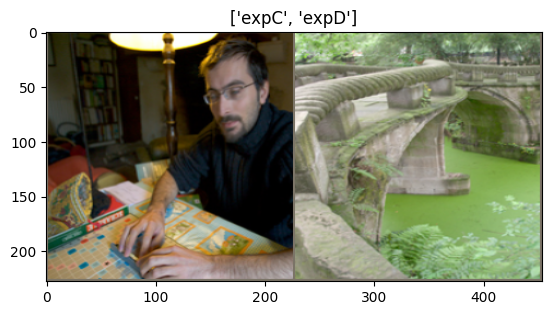

In [16]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))
# Make a grid from first 2 images in the batch
out = torchvision.utils.make_grid(inputs[:2])
imshow(out, title=[class_directories[x] for x in labels[:2]])

In [17]:
print(len(train_dataset))

20000


In [18]:
base_checkpoint_path = config['paths']['checkpoints']
# Create the directory if it does not exist
if not os.path.exists(base_checkpoint_path):
    os.makedirs(base_checkpoint_path)


In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [20]:
def train_model(model, criterion, optimizer, scheduler, current_epoch, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    model.train()
    for epoch in range(current_epoch, num_epochs):
            # formatted string to append epoch number to checkpoint filename
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {get_lr(optimizer):.8f}')
        print()

        PATH = os.path.join(base_checkpoint_path, f'{os.path.basename(base_checkpoint_path)}_{epoch+1}.pth')
        # save checkpoint
        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss,
            'scheduler': scheduler.state_dict(),
            'accuracy': epoch_acc
        }
        # save the best model parameters
        torch.save(state, PATH)
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:4f}')

In [21]:
model_name = config['model']['name']
if not model_name.startswith('resnet'):
    raise ValueError("Model name must start with 'resnet'")

In [22]:
if config['model']['type'] == 'FEATURE_EXTRACTOR':
    model = torchvision.models.__dict__[model_name](weights='IMAGENET1K_V1')
    # Freeze all layers except the fully connected layers
    for param in model.parameters():
        param.requires_grad = False
elif config['model']['type'] == 'FINE_TUNING':
    model = torchvision.models.__dict__[model_name](weights='IMAGENET1K_V1')
elif config['model']['type'] == 'TRAIN_FROM_SCRATCH':
    model = torchvision.models.__dict__[model_name](weights=None)
else:
    raise ValueError(f"Unknown model type: {config['model']['type']}")

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc =  nn.Linear(num_ftrs, config['model']['num_classes'])

# move the model to GPU/CPU
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=config['model']['lr'], momentum=config['model']['momentum'])

milestones = [9, 18, 34, 50, 70]

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [23]:
# load the last model saved if there is any
def load_latest_model(model, optimizer, scheduler, checkpoint_dir):
    # Check if the directory exists
    if not os.path.exists(base_checkpoint_path):
        print(f"No directory found: {checkpoint_dir}")
        return model, optimizer, scheduler, 0, None

    # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, f'{os.path.basename(checkpoint_dir)}_*.pth'))
    print(checkpoint_files)
    # Check if any checkpoint files are present
    if not checkpoint_files:
        print(f"No checkpoints found in the directory: {checkpoint_dir}")
        return model, optimizer, scheduler, 0, None

    # Find the latest checkpoint file based on the epoch number in the filename
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

    # Load the latest checkpoint
    checkpoint = torch.load(latest_checkpoint, map_location=torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(checkpoint['accuracy'])

    print(f"Loaded model from checkpoint: {latest_checkpoint}")
    print(f"Resuming training from epoch {epoch}")

    return model, optimizer,scheduler, epoch, loss


In [24]:
model, optimizer, scheduler, current_epoch, loss = load_latest_model(model, optimizer, scheduler, base_checkpoint_path)

['/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_1.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_2.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_3.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_4.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_5.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_6.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_7.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_8.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_9.pth', '/content/drive/MyDrive/thesis/model/checkpoints/resetnet50_scratch/resetnet50_scratch_10.pth', '/content/drive/MyDrive/thesis/model/checkpoints

In [25]:
print(get_lr(optimizer))

1e-05


In [26]:
train_model(model, criterion, optimizer, scheduler,current_epoch, num_epochs=config['model']['num_epochs'])

Epoch 41/80
----------
Loss: 1.3507 Acc: 0.4365 LR: 0.00001000

Epoch 42/80
----------
Loss: 1.3473 Acc: 0.4355 LR: 0.00001000

Epoch 43/80
----------
Loss: 1.3513 Acc: 0.4387 LR: 0.00001000

Epoch 44/80
----------
Loss: 1.3471 Acc: 0.4394 LR: 0.00001000

Epoch 45/80
----------
Loss: 1.3488 Acc: 0.4363 LR: 0.00001000

Epoch 46/80
----------
Loss: 1.3510 Acc: 0.4395 LR: 0.00001000

Epoch 47/80
----------
Loss: 1.3502 Acc: 0.4351 LR: 0.00001000

Epoch 48/80
----------
Loss: 1.3544 Acc: 0.4328 LR: 0.00001000

Epoch 49/80
----------
Loss: 1.3448 Acc: 0.4406 LR: 0.00001000

Epoch 50/80
----------
Loss: 1.3519 Acc: 0.4361 LR: 0.00000100

Epoch 51/80
----------
Loss: 1.3485 Acc: 0.4318 LR: 0.00000100

Epoch 52/80
----------
Loss: 1.3510 Acc: 0.4348 LR: 0.00000100

Epoch 53/80
----------
Loss: 1.3514 Acc: 0.4356 LR: 0.00000100

Epoch 54/80
----------
Loss: 1.3507 Acc: 0.4352 LR: 0.00000100

Epoch 55/80
----------
Loss: 1.3500 Acc: 0.4365 LR: 0.00000100

Epoch 56/80
----------
Loss: 1.3495 Acc:

In [ ]:
time.sleep(5)  # Sleep for 5 seconds to let the system cool down
from google.colab import runtime
runtime.unassign()